## Naive Bayes Video Classifier
This notebook runs through YouTube Trending Video the classification of YouTube Trending video category based on title using Naive Bayes.

Additionally, we will compare the performance of two specific variants of Navive Bayes
    1. Multinomial Naive Bayes
    2. Bernouli Naive Bayes

In [11]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

### Load in filtered dataset and look at the formatting
The columns of interest at ['filter_title', 'filter_title_no_stops', 'category_id']
    1. 'filter_title' --> raw input that only has punctuation removed and letters to lower case
    2. 'filter_title_no_stops' --> 'filter_title' data with addition to removal of stopwords
    3. 'category_id' --> output/buckets to categorize video (16 total)

In [2]:
df_titles_info = pd.read_csv('./output/US_count_vectorizer_dataset.csv')
df_titles_info.head()

,title,filter_title,filter_title_no_stops,category_id
0,WE WANT TO TALK ABOUT OUR MARRIAGE,we want to talk about our marriage,want talk marriage,People & Blogs
1,The Trump Presidency: Last Week Tonight with J...,the trump presidency last week tonight with jo...,trump presidency last week tonight john oliver...,Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman rudy mancuso king bach lele pons,racist superman rudy mancuso king bach lele pons,Comedy
3,Nickelback Lyrics: Real or Fake?,nickelback lyrics real or fake,nickelback lyrics real fake,Entertainment
4,I Dare You: GOING BALD!?,i dare you going bald,dare going bald,Entertainment


### Separate the dataframe into inputs and outputs

In [3]:
df_x = df_titles_info['filter_title']
df_y = df_titles_info['category_id']

target_names = list(df_titles_info['category_id'].unique())

### Split dataset before vectorizing
This guards against leaking information from testing to training set (80% training, 20% testing)

https://machinelearningmastery.com/data-leakage-machine-learning/
https://stackoverflow.com/questions/54491953/can-i-use-countvectorizer-on-both-test-and-train-data-at-the-same-time-or-do-i-n

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=117)
print("Training data size:", x_train.shape)
print("Testing data size:", x_test.shape)

Training data size: (32759,)
Testing data size: (8190,)


### Tokenizer words using CountVectorizer
Bag-of-Words model that allows both tokenize a collection of text documents and build a vocabulary of known words

The length of each individual vector will be that of the entire dataset which each indices representing the count of a specific word

In [5]:
count_vectorizer = CountVectorizer()
train_count_vector = count_vectorizer.fit_transform(x_train)
test_count_vector = count_vectorizer.transform(x_test)

### Tokenizer words using TfidfTransformer
Will convert our count values from CountVectorizer into a frequency matrix

Term Frequency: How often a word appears in a particular title.
Inverse Document Frequency: Downscale this words that appear often across multiple titles.

Main purpose is to reduce the importance of stopwords that a common accross categories

In [6]:
tfidf_vectorizer = TfidfTransformer()
x_trained_tfidf_vector = tfidf_vectorizer.fit_transform(train_count_vector)
x_test_tfidf_vector = tfidf_vectorizer.transform(test_count_vector)

### Naive Bayes Model Training

In [7]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(x_trained_tfidf_vector, y_train)

clf_count = MultinomialNB()
clf_count.fit(train_count_vector, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Accuracy and Classification Report
Test the accuracy of our model usingth testing dataset

In [29]:
pred_tfidf = clf_tfidf.predict(x_test_tfidf_vector)
print("Tfidf Model")
print("Accuracy: ", accuracy_score(y_test, pred_tfidf))
print("Precision: ", metrics.precision_score(y_test, pred_tfidf, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_tfidf, average='weighted'))
print(metrics.classification_report(y_test, pred_tfidf, target_names=target_names))

pred_count = clf_count.predict(test_count_vector)
print("Count Model")
print("Accuracy: ", accuracy_score(y_test, pred_count))
print("Precision: ", metrics.precision_score(y_test, pred_count, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count, average='weighted'))
print(metrics.classification_report(y_test, pred_count, target_names=target_names))

Tfidf Model
Accuracy:  0.860927960927961
Precision:  0.8821316148369487
F1:  0.8575833321942375


C:\Users\lukev\Anaconda3\envs\yt-trends\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

       People & Blogs       1.00      0.20      0.33        91
        Entertainment       0.92      0.77      0.84       664
               Comedy       0.98      0.79      0.88       329
 Science & Technology       0.72      0.97      0.82      2016
     Film & Animation       0.99      0.75      0.86       495
      News & Politics       1.00      0.59      0.74       149
               Sports       0.89      0.91      0.90       823
                Music       0.91      0.96      0.93      1245
       Pets & Animals       0.96      0.85      0.90       523
            Education       0.00      0.00      0.00        10
        Howto & Style       0.96      0.72      0.82       660
     Autos & Vehicles       0.99      0.77      0.87       186
      Travel & Events       0.91      0.84      0.87       461
               Gaming       1.00      0.57      0.73        14
Nonprofits & Activism       0.94      0.94      0.94  

### Confusion Matrix

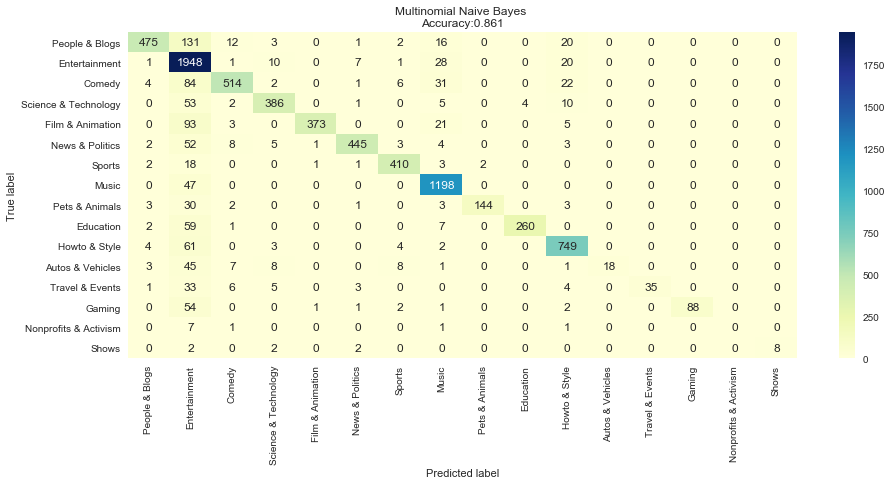

In [9]:
conf_matrix = confusion_matrix(y_test, pred_tfidf, labels=target_names)
conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(15,6))
sns.heatmap(conf_df, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Multinomial Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, pred_tfidf)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Utilize SMOTE to oversample minority classes

In [12]:
smote = SMOTE(sampling_strategy='not majority')

x_train_smote, y_train_smote = smote.fit_sample(train_count_vector, y_train)

print(y_train.value_counts())
print()
print(y_train_smote.value_counts())

Entertainment            7948
Music                    5227
Howto & Style            3323
Comedy                   2793
People & Blogs           2550
News & Politics          1964
Science & Technology     1940
Film & Animation         1850
Sports                   1737
Education                1327
Pets & Animals            734
Gaming                    668
Travel & Events           315
Autos & Vehicles          293
Nonprofits & Activism      47
Shows                      43
Name: category_id, dtype: int64

Education                7948
Entertainment            7948
Science & Technology     7948
Film & Animation         7948
Music                    7948
Howto & Style            7948
Gaming                   7948
Nonprofits & Activism    7948
Pets & Animals           7948
Autos & Vehicles         7948
News & Politics          7948
Sports                   7948
Comedy                   7948
People & Blogs           7948
Travel & Events          7948
Shows                    7948
Name: c

In [30]:
clf_count.fit(x_train_smote, y_train_smote)

pred_count_smote = clf_count.predict(test_count_vector)
print("Count Model")
print("Accuracy: ", accuracy_score(y_test, pred_count_smote))
print("Precision: ", metrics.precision_score(y_test, pred_count_smote, average='weighted'))
print("F1: ", metrics.f1_score(y_test, pred_count_smote, average='weighted'))
print(metrics.classification_report(y_test, pred_count_smote, target_names=target_names))

Count Model
Accuracy:  0.8952380952380953
Precision:  0.899370771639932
F1:  0.8944681277407608
                       precision    recall  f1-score   support

       People & Blogs       0.77      0.95      0.85        91
        Entertainment       0.90      0.84      0.87       664
               Comedy       0.88      0.96      0.92       329
 Science & Technology       0.95      0.79      0.86      2016
     Film & Animation       0.84      0.91      0.88       495
      News & Politics       0.80      0.97      0.88       149
               Sports       0.86      0.94      0.90       823
                Music       0.94      0.95      0.95      1245
       Pets & Animals       0.89      0.94      0.91       523
            Education       0.77      1.00      0.87        10
        Howto & Style       0.85      0.87      0.86       660
     Autos & Vehicles       0.87      0.97      0.92       186
      Travel & Events       0.85      0.95      0.89       461
               Gaming

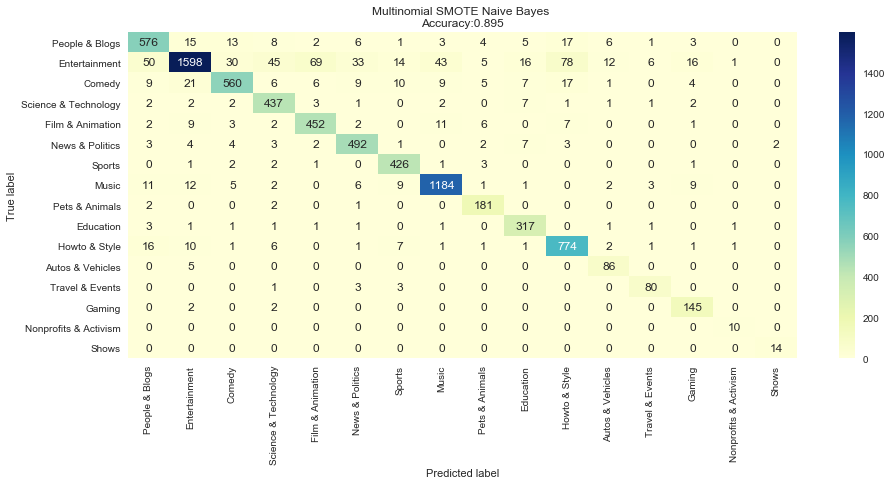

In [31]:
conf_matrix = confusion_matrix(y_test, pred_count_smote, labels=target_names)
conf_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(15,6))
sns.heatmap(conf_df, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Multinomial SMOTE Naive Bayes \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, pred_count_smote)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
bern_count = BernoulliNB()
bern_count.fit(train_count_vector, y_train)

In [ ]:
bern_pred_count = bern_count.predict(test_count_vector)
print("Accuracy: ", accuracy_score(y_test, bern_pred_count))
print(metrics.classification_report(y_test, bern_pred_count, target_names=target_names))